### 1. Import Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

from scipy.stats import uniform
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import matplotlib.pyplot as plt
import os

### 2. Data Preprocessing
#### Load the Dataset

In [ ]:
train_df = pd.read_csv("../data/Amazon_reviews/train_cleaned_final.csv")
test_df = pd.read_csv("../data/Amazon_reviews/test_cleaned_final.csv")

# Extract features and labels
X_train = train_df["clean_review"]
y_train = train_df["sentiment"]
X_test = test_df["clean_review"]
y_test = test_df["sentiment"]

### 3. Exploratory Data Analysis (EDA)
#### Sentiment Distribution

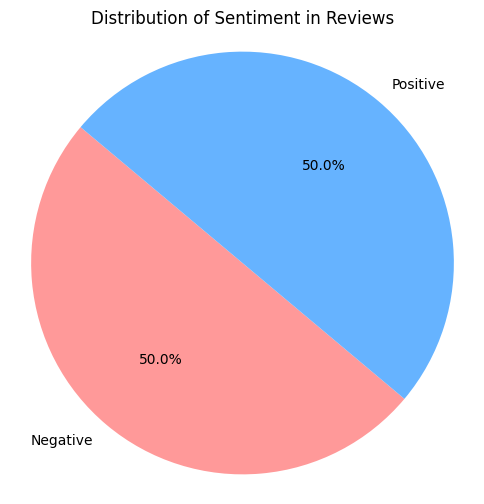

<Figure size 640x480 with 0 Axes>

In [17]:
# Generate sentiment counts
sentiment_counts = train_df["sentiment"].value_counts()
labels = ["Negative", "Positive"]
colors = ["#ff9999", "#66b3ff"]
figures_dir = "./figures"

# Ensure the figure directory exists
os.makedirs(figures_dir, exist_ok=True)

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Distribution of Sentiment in Reviews")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Show the plot in the notebook (instead of saving it)
plt.show()

# Optionally, save the figure to the disk
sentiment_plot_path = os.path.join(figures_dir, "sentiment_distribution.png")
plt.savefig(sentiment_plot_path)


#### Review Length Distribution and Outliers

In [18]:
# Calculate the review length for each review
train_df["review_length"] = train_df["clean_review"].apply(lambda x: len(str(x).split()))

# Plotting the Review Length Distribution (Histogram)
plt.figure(figsize=(8, 5))
sns.histplot(train_df["review_length"], bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()  # Display the histogram inline in the notebook

# Optionally, save the figure
review_length_dist_path = os.path.join(figures_dir, "review_length_distribution.png")
plt.savefig(review_length_dist_path)

# Box plot for outliers
Q1 = train_df["review_length"].quantile(0.25)
Q3 = train_df["review_length"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = train_df[(train_df["review_length"] < lower_bound) | (train_df["review_length"] > upper_bound)]

plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df["review_length"])
plt.title("Box Plot of Review Lengths")
plt.xlabel("Number of Words")
plt.show()  # Display the box plot inline in the notebook

# Optionally, save the box plot figure
outlier_boxplot_path = os.path.join(figures_dir, "outlier_boxplot.png")
plt.savefig(outlier_boxplot_path)


KeyError: 'clean_review'

#### Missing Values and Duplicates

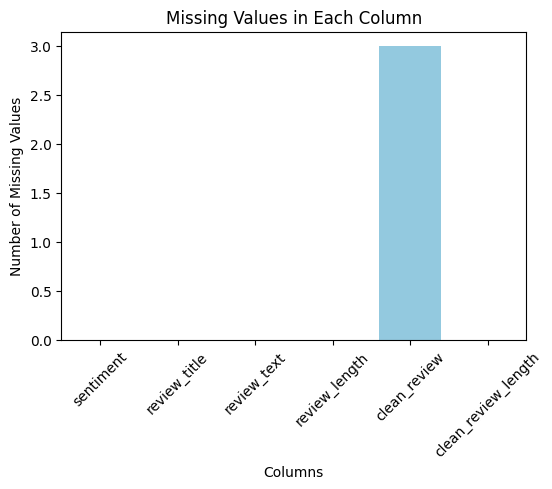

Number of Duplicate Rows: 0


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Checking for missing values
missing_values = train_df.isnull().sum()

# Plotting Missing Values as a bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x=missing_values.index, y=missing_values.values, color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Each Column')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()  # Display the missing values bar plot inline

missing_values_plot_path = os.path.join(figures_dir, "missing_values.png")
plt.savefig(missing_values_plot_path)

# Checking for duplicate rows
duplicates = train_df.duplicated().sum()
print(f"Number of Duplicate Rows: {duplicates}")


#### Handle Missing Values

In [3]:
# Handle missing values in the 'clean_review' column
X_train.fillna("", inplace=True)
X_test.fillna("", inplace=True)

#### TF-IDF Vectorization

In [4]:
vectorizer = joblib.load("./models/tfidf_vectorizer.pkl")

# Transform the text data into TF-IDF features
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### 3. Model Training
#### Train and Save Models

In [5]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
joblib.dump(rf_model, "./models/random_forest_model.pkl")

# Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train)
joblib.dump(dt_model, "./models/decision_tree_model.pkl")

# XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_tfidf, y_train)
joblib.dump(xgb_model, "./models/xgboost_model.pkl")

print("Models trained and saved successfully.")

KeyboardInterrupt: 

### 4. Model Evaluation
#### Define Evaluation Function

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\nEvaluating {model_name} Model:")
    y_pred = model.predict(X_test)
    
    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Display the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    
    # Save the confusion matrix plot
    cm_path = os.path.join("./confusion_matrices", f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()  # Close the plot to free memory

#### Evaluate the Models

In [ ]:
# Load the best models from tuning
rf_best_model = joblib.load("./models/random_forest_model.pkl")
dt_best_model = joblib.load("./models/decision_tree_model.pkl")
xgb_best_model = joblib.load("./models/xgboost_model.pkl")

# Evaluate the models
evaluate_model(rf_best_model, X_test_tfidf, y_test, "Random Forest")
evaluate_model(dt_best_model, X_test_tfidf, y_test, "Decision Tree")
evaluate_model(xgb_best_model, X_test_tfidf, y_test, "XGBoost")

print("\nEvaluation completed successfully!")


### 5. Exploratory Data Analysis (EDA)
#### Sentiment Distribution

In [ ]:
sentiment_counts = train_df["sentiment"].value_counts()
labels = ["Negative", "Positive"]
colors = ["#ff9999", "#66b3ff"]
figures_dir = "./figures"

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Distribution of Sentiment in Reviews")
plt.axis('equal') 
sentiment_plot_path = os.path.join(figures_dir, "sentiment_distribution.png")
plt.savefig(sentiment_plot_path)
plt.close()

#### Review Length Distribution and Outliers

In [ ]:
#### Review Length Distribution and Outliers
train_df["review_length"] = train_df["clean_review"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 5))
sns.histplot(train_df["review_length"], bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Count")
review_length_dist_path = os.path.join(figures_dir, "review_length_distribution.png")
plt.savefig(review_length_dist_path)
plt.close()

# Box plot for outliers
Q1 = train_df["review_length"].quantile(0.25)
Q3 = train_df["review_length"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = train_df[(train_df["review_length"] < lower_bound) | (train_df["review_length"] > upper_bound)]

plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df["review_length"])
plt.title("Box Plot of Review Lengths")
plt.xlabel("Number of Words")
outlier_boxplot_path = os.path.join(figures_dir, "outlier_boxplot.png")
plt.savefig(outlier_boxplot_path)
plt.close()
#### Missing Values and Duplicates
missing_values = train_df.isnull().sum()
plt.figure(figsize=(6, 4))
sns.barplot(x=missing_values.index, y=missing_values.values, color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Each Column')
plt.xticks(rotation=45)  
missing_values_plot_path = os.path.join(figures_dir, "missing_values.png")
plt.savefig(missing_values_plot_path)
plt.close()

# Checking for duplicate rows
duplicates = train_df.duplicated().sum()
print(f"Number of Duplicate Rows: {duplicates}")

In [ ]:
missing_values = train_df.isnull().sum()
plt.figure(figsize=(6, 4))
sns.barplot(x=missing_values.index, y=missing_values.values, color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Each Column')
plt.xticks(rotation=45)  
missing_values_plot_path = os.path.join(figures_dir, "missing_values.png")
plt.savefig(missing_values_plot_path)
plt.close()

# Checking for duplicate rows
duplicates = train_df.duplicated().sum()
print(f"Number of Duplicate Rows: {duplicates}")

### 6. Model Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning using RandomizedSearchCV

# For Random Forest, Decision Tree, and XGBoost as needed

#### 1. Random Forest Hyperparameter Tuning
##### We'll use RandomizedSearchCV to tune the hyperparameters of the Random Forest model. It allows us to randomly sample from a defined hyperparameter grid and find the best combination.


In [ ]:
# Define hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': randint(100, 300),     # Number of trees
    'max_depth': [10, 20, None],            # Maximum depth of trees
    'min_samples_split': randint(2, 10),    # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10),     # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]              # Whether to use bootstrap samples when building trees
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform Randomized Search with 3-fold cross-validation
rf_random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param_grid,
    n_iter=50,       # Number of random parameter combinations to try
    cv=3,            # 3-fold cross-validation
    verbose=2,       # Print progress
    random_state=42, # Set random seed for reproducibility
    n_jobs=-1        # Use all available CPU cores
)

# Fit the model to the training data
rf_random_search.fit(X_train_tfidf, y_train)

# Display the best parameters and best score
print(f"Best Parameters for Random Forest: {rf_random_search.best_params_}")
print(f"Best Score for Random Forest: {rf_random_search.best_score_:.4f}")

# Save the best model
joblib.dump(rf_random_search.best_estimator_, "./models/random_forest_best_model.pkl")

#### 2. Decision Tree Hyperparameter Tuning
##### For Decision Tree, we can tune parameters like max_depth, min_samples_split, and min_samples_leaf.

In [ ]:
# Define hyperparameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [10, 20, None],           # Maximum depth of tree
    'min_samples_split': randint(2, 10),   # Minimum samples required to split an internal node
    'min_samples_leaf': randint(1, 10),    # Minimum samples required to be at a leaf node
    'criterion': ['gini', 'entropy']      # The function to measure the quality of a split
}

# Create the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Perform Randomized Search with 3-fold cross-validation
dt_random_search = RandomizedSearchCV(
    dt_model,
    param_distributions=dt_param_grid,
    n_iter=30,       # Number of random parameter combinations to try
    cv=3,            # 3-fold cross-validation
    verbose=2,       # Print progress
    random_state=42, # Set random seed for reproducibility
    n_jobs=-1        # Use all available CPU cores
)

# Fit the model to the training data
dt_random_search.fit(X_train_tfidf, y_train)

# Display the best parameters and best score
print(f"Best Parameters for Decision Tree: {dt_random_search.best_params_}")
print(f"Best Score for Decision Tree: {dt_random_search.best_score_:.4f}")

# Save the best model
joblib.dump(dt_random_search.best_estimator_, "./models/decision_tree_best_model.pkl")

#### 3. XGBoost Hyperparameter Tuning
##### For XGBoost, the most important hyperparameters to tune include learning_rate, n_estimators, max_depth, and subsample.

In [ ]:
# Define hyperparameter grid for XGBoost
xgb_param_grid = {
    'learning_rate': uniform(0.01, 0.1),    # The step size for each boosting round
    'n_estimators': randint(100, 300),      # Number of boosting rounds (similar to epochs)
    'max_depth': randint(3, 8),              # Maximum depth of a tree
    'subsample': uniform(0.7, 0.3),          # Fraction of data used to train each tree
    'colsample_bytree': uniform(0.7, 0.3)   # Fraction of features used to train each tree
}

# Create the XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)

# Perform Randomized Search with 3-fold cross-validation
fit_params = {
    "eval_set": [(X_val_tfidf, y_val)],    # Define the validation set for early stopping
    "early_stopping_rounds": 10,           # Stop if validation error doesn't improve for 10 rounds
    "verbose": False
}

xgb_random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=30,       # Number of random parameter combinations to try
    cv=3,            # 3-fold cross-validation
    verbose=2,       # Print progress
    random_state=42, # Set random seed for reproducibility
    n_jobs=-1        # Use all available CPU cores
)

# Fit the model to the training data
xgb_random_search.fit(X_train_tfidf, y_train, **fit_params)

# Display the best parameters and best score
print(f"Best Parameters for XGBoost: {xgb_random_search.best_params_}")
print(f"Best Score for XGBoost: {xgb_random_search.best_score_:.4f}")

# Save the best model
joblib.dump(xgb_random_search.best_estimator_, "./models/xgboost_best_model.pkl")
